In [31]:
dict_wl_sims = {}
# dict_rw_sims = {}
dict_matching_labels = {}
dict_gin_sims = {}
# num_samples = 20

In [13]:
%load_ext autoreload
%autoreload 2

import argparse
from itertools import product

from datasets import get_dataset
from gin import GIN
from train_eval import cross_validation_with_val_set

from torch_geometric.utils import to_networkx
import torch

import grakel
from grakel.kernels import WeisfeilerLehman, VertexHistogram, RandomWalk
from grakel.utils import graph_from_networkx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--lr_decay_factor', type=float, default=0.5)
parser.add_argument('--lr_decay_step_size', type=int, default=50)
args = parser.parse_args("")

layers = [4]
hiddens = [64]
all_datasets = ['IMDB-BINARY', 'IMDB-MULTI', 'REDDIT-BINARY', 'MUTAG', 'PTC_MR', 'PROTEINS']
nets = [GIN]

In [4]:
dict_nx_dataset = {}
dict_labels = {}
dict_torch_dataset = {}

for dataset_name in all_datasets:
    torch_dataset = []
    nx_dataset = []
    labels = []
    
    dataset = get_dataset(dataset_name)
    
    for G_torch in dataset:
        G_nx = to_networkx(G_torch, node_attrs=['x'])
        # convert node attrs to tuple so are hashable
        for node in G_nx.nodes():
            if isinstance(G_nx.nodes[node]['x'], list):
                G_nx.nodes[node]['x'] = tuple(G_nx.nodes[node]['x'])
        
        torch_dataset.append(G_torch)
        nx_dataset.append(G_nx)
        labels.append(G_torch.y[0].item())
        
    nx_dataset = list(zip(nx_dataset, labels, torch_dataset))
    # nx_dataset = random.sample(nx_dataset, num_samples)
    torch_dataset = list(list(zip(*nx_dataset))[2])
    labels = list(list(zip(*nx_dataset))[1])
    nx_dataset = list(list(zip(*nx_dataset))[0])
    
    dict_nx_dataset[dataset_name] = nx_dataset
    dict_labels[dataset_name] = labels
    dict_torch_dataset[dataset_name] = torch_dataset

In [5]:
for dataset_name in all_datasets:

    print("======", dataset_name, "======")
    nx_dataset = dict_nx_dataset[dataset_name]
    gd = list(graph_from_networkx(nx_dataset, node_labels_tag='x'))
    
    wl_gk = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
    wl_sims = wl_gk.fit_transform(gd)
    dict_wl_sims[dataset_name] = wl_sims
    
#     rw_gk = RandomWalk(normalize=True)
#     rw_sims = rw_gk.fit_transform(gd)
#     dict_rw_sims[dataset_name] = rw_sims

====== IMDB-BINARY ======
====== IMDB-MULTI ======
====== REDDIT-BINARY ======
====== MUTAG ======
====== PTC_MR ======
====== PROTEINS ======


In [32]:
import numpy as np

# for dataset_name in all_datasets:
        
#     with open('./kernels/{}_wl.npy'.format(dataset_name), 'wb') as f:
#         np.save(f, dict_wl_sims[dataset_name], allow_pickle=True)
        
# #     with open('./kernels/{}_rw.npy'.format(dataset_name), 'wb') as f:
# #         np.save(f, dict_rw_sims[dataset_name])

for dataset_name in all_datasets:
    with open('./kernels/{}_wl.npy'.format(dataset_name), 'rb') as f:
        dict_wl_sims[dataset_name] = np.load(f, allow_pickle=True)
        
    print(dict_wl_sims[dataset_name].shape)

(1000, 1000)
(1500, 1500)
(2000, 2000)
(188, 188)
(344, 344)
(1113, 1113)


In [34]:
for dataset_name in all_datasets:
    
    print("======", dataset_name, "======")
    
    labels = dict_labels[dataset_name]
    matching_labels = torch.zeros(len(labels), len(labels))
    for idx_i, lbl_i in enumerate(labels):
        for idx_j, lbl_j in enumerate(labels):
            if lbl_i == lbl_j:
                matching_labels[idx_i, idx_j] = 1
    dict_matching_labels[dataset_name] = matching_labels

====== IMDB-BINARY ======
====== IMDB-MULTI ======
====== REDDIT-BINARY ======
====== MUTAG ======
====== PTC_MR ======
====== PROTEINS ======


In [10]:
from torch_geometric import seed_everything
seed_everything(42)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

results = []
models = []
for dataset_name, Net in product(all_datasets, nets):
    best_result = (float('inf'), 0, 0)  # (loss, acc, std)
    best_model = None
    print(f'--\n{dataset_name} - {Net.__name__}')
    for num_layers, hidden in product(layers, hiddens):
        print(f'--\n{num_layers} - {hidden}')
        dataset = get_dataset(dataset_name)
        model = Net(dataset, num_layers, hidden).to(device)
        loss, acc, std = cross_validation_with_val_set(
            dataset,
            model,
            folds=10,
            epochs=args.epochs,
            batch_size=args.batch_size,
            lr=args.lr,
            lr_decay_factor=args.lr_decay_factor,
            lr_decay_step_size=args.lr_decay_step_size,
            weight_decay=0,
            logger=None,
        )
        if loss < best_result[0]:
            best_result = (loss, acc, std)
            best_model = model

    desc = f'{best_result[1]:.3f} ± {best_result[2]:.3f}'
    print(f'Best result - {desc}')
    results += [f'{dataset_name} - {model}: {desc}']
    models.append(best_model)
results = '\n'.join(results)
print(f'--\n{results}')

--
IMDB-BINARY - GIN
--
4 - 64
0
1
2
3
4
5
6
7
8
9
Val Loss: 0.4568, Test Accuracy: 0.719 ± 0.052, Duration: 36.574
Best result - 0.719 ± 0.052
--
IMDB-MULTI - GIN
--
4 - 64
0
1
2
3
4
5
6
7
8
9
Val Loss: 0.9455, Test Accuracy: 0.498 ± 0.016, Duration: 47.387
Best result - 0.498 ± 0.016
--
REDDIT-BINARY - GIN
--
4 - 64
0
1
2
3
4
5
6
7
8
9
Val Loss: 0.2097, Test Accuracy: 0.913 ± 0.022, Duration: 50.597
Best result - 0.913 ± 0.022
--
MUTAG - GIN
--
4 - 64
0
1
2
3
4
5
6
7
8
9
Val Loss: 0.2253, Test Accuracy: 0.862 ± 0.051, Duration: 4.000
Best result - 0.862 ± 0.051
--
PTC_MR - GIN
--
4 - 64
0
1
2
3
4
5
6
7
8
9
Val Loss: 0.6299, Test Accuracy: 0.567 ± 0.062, Duration: 5.981
Best result - 0.567 ± 0.062
--
PROTEINS - GIN
--
4 - 64
0
1
2
3
4
5
6
7
8
9
Val Loss: 0.5271, Test Accuracy: 0.713 ± 0.035, Duration: 14.939
Best result - 0.713 ± 0.035
--
IMDB-BINARY - GIN: 0.719 ± 0.052
IMDB-MULTI - GIN: 0.498 ± 0.016
REDDIT-BINARY - GIN: 0.913 ± 0.022
MUTAG - GIN: 0.862 ± 0.051
PTC_MR - GIN: 0.567 ±

In [ ]:
from torch_geometric.loader import DataLoader

for dataset_name, model in zip(all_datasets, models):
    dataset = get_dataset(dataset_name)
    test_loader = DataLoader(dataset, len(dataset), shuffle=False) 
    
    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            x_repr = model(data, ret_repr=True)
    
            normed_x_repr = x_repr / x_repr.norm(dim=1, keepdim=True)
            dict_gin_sims[dataset_name] = (normed_x_repr @ normed_x_repr.T).cpu().detach()
            
            with open('./kernels/{}_gin.npy'.format(dataset_name), 'wb') as f:
                np.save(f, dict_gin_sims[dataset_name], allow_pickle=True)

In [35]:
for dataset_name in all_datasets:
    with open('./kernels/{}_gin.npy'.format(dataset_name), 'rb') as f:
        dict_gin_sims[dataset_name] = np.load(f, allow_pickle=True)
        
    print(dict_gin_sims[dataset_name].shape)

(1000, 1000)
(1500, 1500)
(2000, 2000)
(188, 188)
(344, 344)
(1113, 1113)


In [36]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [59]:
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score

def calc_MI(x, y, bins=20):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

====== IMDB-BINARY ======
====== IMDB-MULTI ======
====== REDDIT-BINARY ======
====== MUTAG ======
====== PTC_MR ======
====== PROTEINS ======


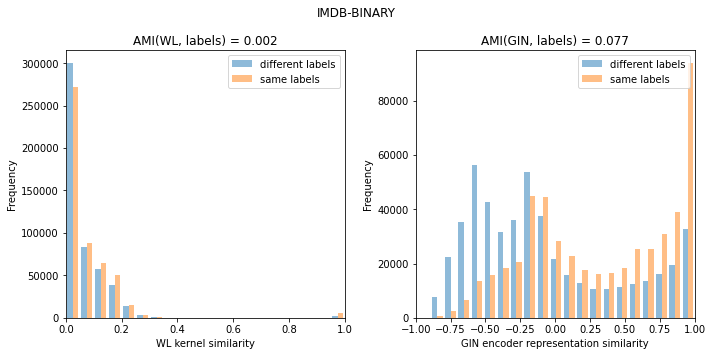

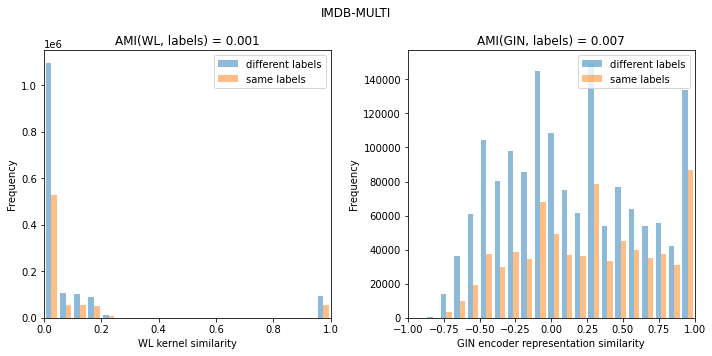

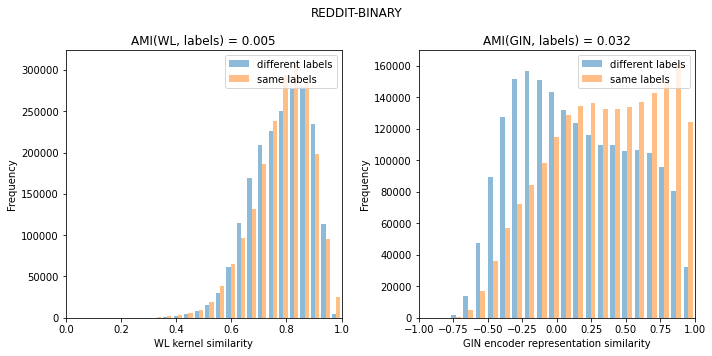

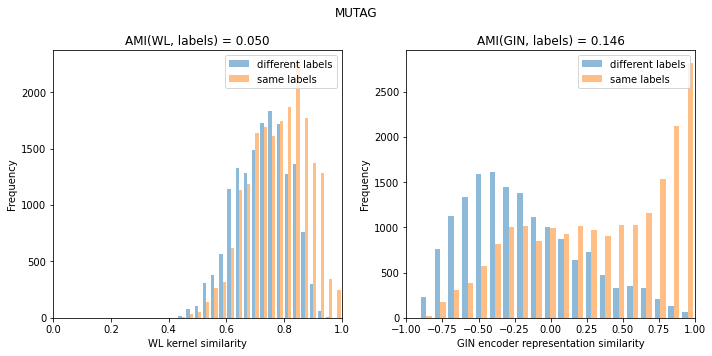

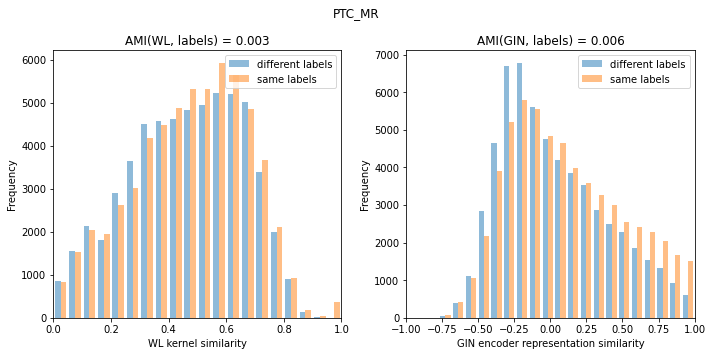

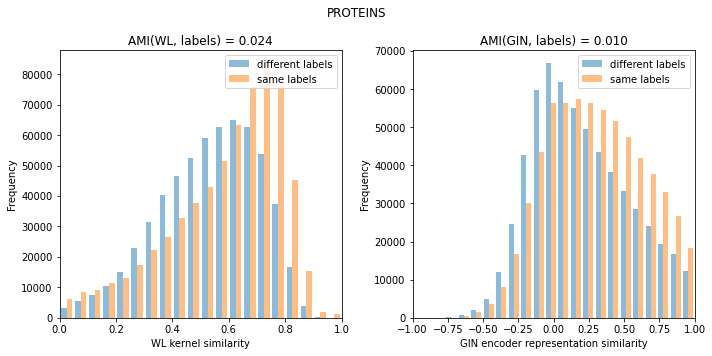

In [60]:
import matplotlib.pyplot as plt

for dataset_name in all_datasets:
    print("======", dataset_name, "======")
    
    wl_sims = dict_wl_sims[dataset_name]
    gin_sims = dict_gin_sims[dataset_name]
    matching_labels = dict_matching_labels[dataset_name].numpy()

    plt.figure(figsize=(10, 5))
    
    # wl_mask = ~is_outlier(wl_sims.flatten())
    wl_mask = wl_sims.flatten() == wl_sims.flatten()
    
    plt.subplot(1, 2, 1)
    d1 = wl_sims.flatten()[wl_mask][matching_labels.flatten()[wl_mask] == 0]
    d2 = wl_sims.flatten()[wl_mask][matching_labels.flatten()[wl_mask] == 1]
    plt.hist([d1, d2], bins=20, alpha=0.5, label=['different labels', 'same labels'])
    plt.xlim(0, 1)
    
    # association = np.corrcoef(wl_sims.flatten(), matching_labels.flatten())[0, 1]
    association = calc_MI(wl_sims.flatten(), matching_labels.flatten())
    
    plt.title('MI(WL, labels) = ' + '{0:.3f}'.format(association))
    plt.legend(loc='upper right')
    plt.ylabel("Frequency")
    plt.xlabel("WL kernel similarity")
    
    # gin_mask = ~is_outlier(gin_sims.flatten())
    gin_mask = gin_sims.flatten() == gin_sims.flatten()
    
    plt.subplot(1, 2, 2)
    d1 = gin_sims.flatten()[gin_mask][matching_labels.flatten()[gin_mask] == 0]
    d2 = gin_sims.flatten()[gin_mask][matching_labels.flatten()[gin_mask] == 1]
    plt.hist([d1, d2], bins=20, alpha=0.5, label=['different labels', 'same labels'])
    plt.xlim(-1, 1)
    
    # association = np.corrcoef(gin_sims.flatten(), matching_labels.flatten())[0, 1]
    association = calc_MI(gin_sims.flatten(), matching_labels.flatten())
    
    plt.title('MI(GIN, labels) = ' + '{0:.3f}'.format(association))
    plt.legend(loc='upper right')
    plt.ylabel("Frequency")
    plt.xlabel("GIN encoder representation similarity")
    
    plt.suptitle(dataset_name)
    plt.tight_layout()
    
    plt.savefig("./plots/alignment/{}.pdf".format(dataset_name))